(https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Cassandra1.jpeg/800px-Cassandra1.jpeg)
## Notebook to run serial methods

With this notebook you can run live/backtest Kaissandra, plot live results and much more

In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")
    
import pandas as pd
import datetime as dt
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


## Init Util Functions and Constants 

In [2]:
def get_positions_filename(asset, open_dt, close_dt):
    """  """
    
    dt_open = dt.datetime.strftime(dt.datetime.strptime(
            open_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    dt_close = dt.datetime.strftime(dt.datetime.strptime(
            close_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    filename = 'O'+dt_open+'C'+dt_close+asset
    return filename

In [3]:
live = True
config_name = 'TTEST10'#'TPRODN01010N01011'#'T0003'
if live:
    ext = '_LI_'
    directory = 'live'
    start_time = '19_05_02_15_41_33'#'19_04_29_18_39_03'
else:
    ext = '_BT_'
    directory = 'back_test'
    start_time = '19_02_19_14_23_40'#'19_02_15_17_30_37'
results_dir = '../../RNN/resultsLive/'+directory+'/trader/'
positions_dir = '../../RNN/resultsLive/'+directory+'/positions/'+start_time+config_name+'/'
pos_dirname = results_dir
pos_filename_soll = start_time+ext+"positions_soll.log"
pos_filename_ist = start_time+ext+"positions_ist.log"
filename_soll = results_dir+start_time+ext+config_name+"positions_soll.log"
filename_ist = results_dir+start_time+ext+config_name+"positions_ist.log"
positions_soll = pd.read_csv(filename_soll).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)
positions_ist = pd.read_csv(filename_ist).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)
#print(pd.read_csv(positions_dir+filename_pos+'.txt'))#'O190502152953C190502152953GBPCAD.txt'

In [ ]:
# Calculate dissagreement in ROIs
print("Mean error in pips between soll and ist: "+str(np.mean(np.abs(positions_ist.ROI-positions_soll.ROI))/0.01))
print((np.abs(positions_ist.ROI-positions_soll.ROI))/0.01)
print(pd.to_datetime(positions_soll['Entry Time'])-pd.to_datetime(positions_ist['Entry Time']))
#print(positions_ist)
print(positions_ist.Asset)
print(positions_soll)

In [ ]:
O190502152919C190502152953GBPCAD.txt
O190502152953C190502152953GBPCAD.txt

TTEST10
Total GROI = 0.01% Total ROI = -0.53% total profit = -10.65e mean spread = 1.22 pips expected mean spread = 1.18 pips 
Number entries 45 GSP = 51.11%  NSP = 20.00%  av win = 0.012%  av lose = -0.013% 
Percent below 2p 100.00%
-0.06290514364620023


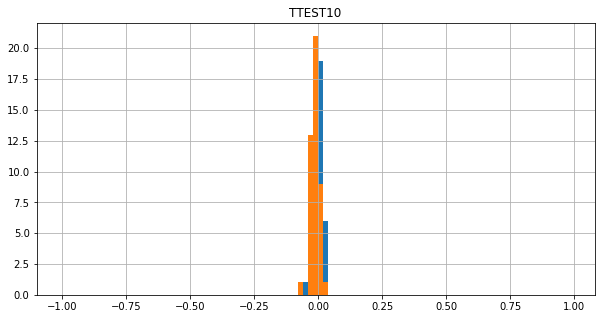

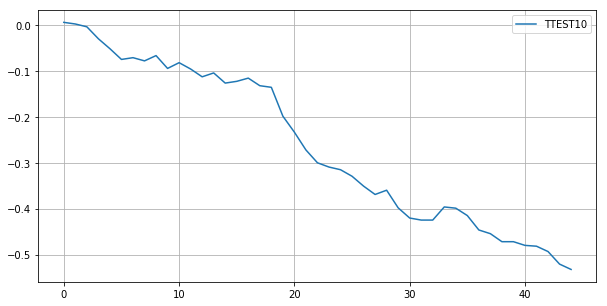

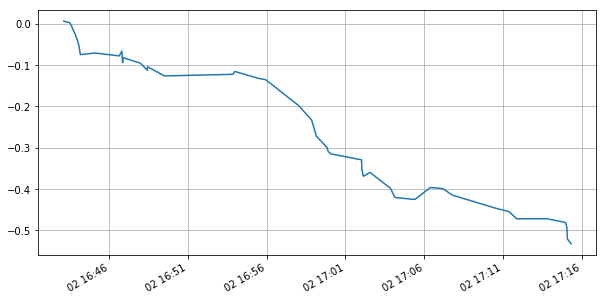

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

import pandas as pd

plt.rcParams['figure.figsize'] = [10, 5]
live = False

#config_names = ['T0004','T0005','T0006','T0007','T0008','']
#legends = ['T0004','T0005','T0006','T0007','T0008','T0003']
#start_times = ['19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_15_17_30_37']#

#config_names = ['T0009','T0010','T0011']#['T0004','T0005','T0006','T0007','T0008','']
#legends = ['T0009','T0010','T0011']#['T0004','T0005','T0006','T0007','T0008','T0003']
#start_times = ['19_02_21_20_34_40','19_02_21_20_34_40','19_02_21_20_34_40']#['19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_19_14_23_40','19_02_15_17_30_37']#

config_names = [config_name]
start_times = [start_time]
legends = config_names

#if live:
#    ext = '_LI_'
#    directory = 'kaissandra_live/live'
#    start_time = '19_01_27_23_18_41'
#else:
#    ext = '_BT_'
#    directory = 'back_test'
#    #start_time = '19_02_15_17_30_37'#'19_02_19_14_23_40'
#results_dir = '../../RNN/resultsLive/'+directory+'/trader/'
pos_dirname = results_dir
#pos_filename = start_time+ext+"positions_soll.log"
filenames = [results_dir+start_times[i]+ext+config_names[i]+"positions_soll.log" for i in range(len(config_names))]
positions_list =  [pd.read_csv(filename).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1) for filename in filenames]
#print(positions)

for i in range(len(config_names)):
    #print(positions.GROI.sum())
    #print(positions.ROI.sum())
    #print(positions.Profit.sum())
    #print(positions.Profit)
    config_name = config_names[i]
    print(config_name)
    positions = positions_list[i]
    
    tgroi = positions['GROI'].sum()
    troi = positions['ROI'].sum()
    tprofit = positions['Profit'].sum()
    mspread = positions['Spread'].mean()
    emspread = positions['E_spread'].mean()
    SIs = positions.agg({'GROI': lambda x: 100*np.sum(x>0)/len(x),
                          'ROI': lambda x: 100*np.sum(x>0)/len(x)})
    try:
        av_win = sum(positions[positions['GROI']>0]['GROI'])/len(positions[positions['GROI']>0]['GROI'])
    except ZeroDivisionError:
        av_win = 0
    try:
        av_lose = sum(positions[positions['GROI']<0]['GROI'])/len(positions[positions['GROI']<0]['GROI'])
    except ZeroDivisionError:
        av_lose = 0
    per_under_2p = 100*positions[positions['Spread']<0.02].shape[0]/positions.shape[0]

    print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+\
          "total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
          "expected mean spread = {0:.2f} pips ".format(100*emspread))
    print("Number entries "+str(positions.shape[0])+" GSP = {0:.2f}% ".format(SIs['GROI'])\
          +" NSP = {0:.2f}% ".format(SIs['ROI'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
    print("Percent below 2p {0:.2f}%".format(per_under_2p))
    #print(pd.DataFrame(prob_rois))
    grouped = positions.groupby(['Asset'])
    #print(grouped.get_group(('GBPJPY',1)).to_string())
    #grouped.aggregate(np.sum)
    #grouped['groi'].describe()
    #grouped.get_group('GBPJPY')
    SI = grouped.agg({'GROI': lambda x: np.sum(x>0)/len(x),
                 'ROI': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
    grouped.agg({'E_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
    #print(SI)
    #print(grouped.describe())
    #for name, group in grouped:
        #print(name)
    #    print(group.to_string())
    
    plt.figure(i)
    gran = 100
    min_h = int(gran*np.floor(positions['GROI'].min()))
    max_h = int(gran*np.ceil(positions['GROI'].max()))
    print(positions['ROI'].min())
    #print(positions['GROI'].max())
    bins = [i/gran for i in range(min_h,max_h,2)]
    histG = plt.hist(positions['GROI'], bins=bins)
    histR = plt.hist(positions['ROI'], bins=bins)
    plt.grid()
    plt.title(config_name)

    #pos_under_thr.index = range(pos_under_thr.shape[0])
    plt.figure(100)
    #plt.plot(range(positions.shape[0]),positions['GROI'].cumsum())
    plt.plot(range(positions.shape[0]),positions['ROI'].cumsum(),label=legends[i])
    plt.grid()
    plt.legend()

    list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['Entry Time']]
    dates = matplotlib.dates.date2num(list_dates)
    plt.figure(101)
    #plt.plot_date(list_dates, positions['GROI'].cumsum(),fmt='-')
    plt.plot_date(list_dates, positions['ROI'].cumsum(),fmt='-',label=legends[i])
    plt.gcf().autofmt_xdate()
    plt.grid()
    list_dates_live = list_dates
    positions_live = positions
    #plt.legend()

In [ ]:
from kaissandra.config import *

configT4=retrieve_config('T0004')
print(configT4['netNames'])
print(configT4['list_spread_ranges'])
print(positions_list[0]['strategy'].unique())
configT5=retrieve_config('T0005')
print(configT5['list_name'])
print(positions_list[1]['strategy'].unique())
print(configT5['list_feats_from'])
configT6=retrieve_config('T0006')
print(configT6['list_name'])
print(positions_list[2]['strategy'].unique())
#print(configT6)
configT7=retrieve_config('T0007')
print(configT7['list_name'])
print(positions_list[3]['strategy'].unique())
print(configT7['list_spread_ranges'])
configT8=retrieve_config('T0008')
print(configT8['list_name'])
print(positions_list[4]['strategy'].unique())
print(configT8['list_feats_from'])
configT3=retrieve_config('T0003')
print(configT3['list_name'])
print(configT3['netNames'])
print(configT3['list_spread_ranges'])

In [ ]:
positions_list[2].sort_values(by=['ROI'],ascending=True).reset_index()

In [43]:
positions_dir

'../../RNN/resultsLive/live/positions/19_05_02_14_27_47TTEST10/'

## Build Stats File and Plot Positions

In [ ]:
from tqdm import tqdm
columns = ['asset','Di','Ti','Do','To','direction','groi','roi','profit','e_spread','spread','max','min','argmax','argmin','samples','extensions','stoploss','file']

if_plot = True
plt_index = 0
idx_config = 0
positions = positions_list[idx_config]
config_name = config_names[idx_config]
start_time = start_times[idx_config]
pos_format = pd.DataFrame(data=0,columns=columns,index=range(positions.shape[0]))
#positions_dir = '../../RNN/resultsLive/'+directory+'/positions/'+start_time+config_name+'/'
for p in tqdm(range(positions.shape[0])):
    #print(str(p)+" out of "+str(positions.shape[0]))
    pos_format['asset'].iloc[p] = positions['Asset'].iloc[p]
    pos_format['Di'].iloc[p] = positions['Entry Time'].iloc[p][:10]
    pos_format['Ti'].iloc[p] = positions['Entry Time'].iloc[p][11:]
    pos_format['Do'].iloc[p] = positions['Exit Time'].iloc[p][:10]
    pos_format['To'].iloc[p] = positions['Exit Time'].iloc[p][11:]
    pos_format['groi'].iloc[p] = positions['GROI'].iloc[p]
    pos_format['roi'].iloc[p] = positions['ROI'].iloc[p]
    pos_format['e_spread'].iloc[p] = positions['E_spread'].iloc[p]
    pos_format['spread'].iloc[p] = positions['Spread'].iloc[p]
    pos_format['profit'].iloc[p] = positions['Profit'].iloc[p]
    pos_format['stoploss'].iloc[p] = positions['stoploss'].iloc[p]
    direction = positions['Position'].iloc[p]
    pos_format['direction'].iloc[p] = direction
    filename_pos = get_positions_filename(positions_ist['Asset'].iloc[p], positions_ist['Entry Time'].iloc[p], positions_ist['Exit Time'].iloc[p])
    pos_format['file'].iloc[p] = filename_pos
    pos_ev = pd.read_csv(positions_dir+filename_pos+'.txt', sep=',')
    pos_track = pickle.load( open( positions_dir+filename_pos+".p", "rb" ))
    pos_format['extensions'].iloc[p] = pos_track['n_ext']
    pos_format['samples'].iloc[p] = pos_ev.shape[0]
    #print(pos_ev.columns)
    maxBid = pos_ev['SymbolBid'].max()
    minBid = pos_ev['SymbolBid'].min()
    maxAsk = pos_ev['SymbolAsk'].max()
    minAsk = pos_ev['SymbolAsk'].min()
    Bi = positions['Bi'].iloc[p]
    Ai = positions['Ai'].iloc[p]
    #if direction>0:
    #        GROI_live = roi_ratio*(Ao-Ai)/Ai
    #        spread = (Ao-Bo)/Ai
    #        
    #    else:
    #        GROI_live = roi_ratio*(Bi-Bo)/Ao
    if direction>0:
        pos_format['max'].iloc[p] = 100*(maxAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['min'].iloc[p] = 100*(minAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['argmax'].iloc[p] = pos_ev['SymbolAsk'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolAsk'].idxmin()
        groi_ev = 100*(pos_ev['SymbolAsk'].iloc[:]-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        label = 'long'
    else:
        pos_format['max'].iloc[p] = 100*(positions['Bi'].iloc[p]-minBid)/maxAsk
        pos_format['min'].iloc[p] = 100*(positions['Bi'].iloc[p]-maxBid)/maxAsk
        pos_format['argmax'].iloc[p] = pos_ev['SymbolBid'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolBid'].idxmin()
        groi_ev = 100*(positions['Bi'].iloc[p]-pos_ev['SymbolBid'].iloc[:])/pos_ev['SymbolAsk'].iloc[:]
        label = 'short'
    if positions['GROI'].iloc[p]>0:
        color = 'green'
    else:
        color = 'red'
    if if_plot:
        plt.figure(plt_index)
        plt.plot(groi_ev, color=color, label=label)
        for e in range(pos_track['n_ext']):
            plt.plot([pos_track['@tick#'][e+1] for i in range(2)],[pos_format['min'].iloc[p], pos_format['max'].iloc[p]])
        plt.legend()
        plt.title(filename_pos)
        plt_index += 1
print(pos_format.to_string())
pos_format.to_csv(positions_dir+config_name+'stats.csv', index=False, sep='\t', float_format='%.5f')
print("Positions summary saved")

In [70]:
O190502165529C190502165606GBPCAD
O190502165528C190502165606GBPCAD

[    Asset           Entry Time            Exit Time  Position       Bi  \
 0  GBPCAD  2019.05.02 16:15:22  2019.05.02 16:15:55         1  1.75592   
 
         Ai      Bo       Ao  ticks_d      GROI    Spread       ROI  strategy  \
 0  1.75617  1.7558  1.75608        0 -0.005125  0.015944 -0.021069  TEST1000   
 
      Profit  E_spread  stoploss    stGROI     stROI  
 0 -0.421372  0.013097         2 -0.005125 -0.021069  ]

## Get Summary from Position Stats

In [ ]:
tgroi = pos_format['groi'].sum()
troi = pos_format['roi'].sum()
tprofit = pos_format['profit'].sum()
mspread = pos_format['spread'].mean()
emspread = pos_format['e_spread'].mean()
SIs = pos_format.agg({'groi': lambda x: 100*np.sum(x>0)/len(x),
                      'roi': lambda x: 100*np.sum(x>0)/len(x)})
av_win = sum(pos_format[pos_format['groi']>0]['groi'])/len(pos_format[pos_format['groi']>0]['groi'])
av_lose = sum(pos_format[pos_format['groi']<0]['groi'])/len(pos_format[pos_format['groi']<0]['groi'])
per_under_2p = 100*pos_format[pos_format['e_spread']<0.02].shape[0]/pos_format.shape[0]

print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+"total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
      "expected mean spread = {0:.2f} pips ".format(100*emspread))
print("Number entries "+str(pos_format.shape[0])+" GSP = {0:.2f}% ".format(SIs['groi'])+" NSP = {0:.2f}% ".format(SIs['roi'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
print("Percent below 2p {0:.2f}%".format(per_under_2p))
#print(pd.DataFrame(prob_rois))
grouped = pos_format.groupby(['asset'])
#print(grouped.get_group(('GBPJPY',1)).to_string())
#grouped.aggregate(np.sum)
#grouped['groi'].describe()
#grouped.get_group('GBPJPY')
SI = grouped.agg({'groi': lambda x: np.sum(x>0)/len(x),
             'roi': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
grouped.agg({'e_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
#print(SI)
#print(grouped.describe())
#for name, group in grouped:
    #print(name)
#    print(group.to_string())

## Run Kaissandra Online

In [ ]:
from kaissandra.serial import launch
launch(config_names=['TPRODN01010'], running_assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32], 
       synchroned_run=False)

In [ ]:
import kaissandra.control as ct
ct.pause()

In [ ]:
import kaissandra.control as ct
ct.resume()

In [ ]:
import kaissandra.control as ct
ct.shutdown()

In [ ]:
from kaissandra.prod.control import close_positions
close_positions()

In [ ]:
from kaissandra.prod.control import close_position
close_position('EURUSD')

In [ ]:
from kaissandra.prod.control import control
control([7,10,12,14],15)

In [ ]:
# runLive in multiple processes
from multiprocessing import Process
import datetime as dt
import time
%load_ext autoreload
%autoreload 2

from kaissandra.runLive import run

assets = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19, 27, 28, 29, 30, 31, 32]#
running_assets = assets#[7, 14]
start_time = dt.datetime.strftime(dt.datetime.now(),'%y_%m_%d_%H_%M_%S')
#disp = Process(target=run, args=[running_assets,start_time])
#disp.start()
for ass_idx in range(len(running_assets)):
    disp = Process(target=run, args=[running_assets[ass_idx:ass_idx+1],start_time])
    disp.start()
    time.sleep(2)

## Get total returns

In [ ]:
import pandas as pd
start_time = '19_02_15_17_30_37'
results_dir = '../../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_BT_'+"positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)

In [ ]:
import pandas as pd
start_time = '19_04_09_12_01_10'
results_dir = '../../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_BT_'+"T01010-1k1k2positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)


## Retrieve Positions from Trader Simulation

In [ ]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 3
start_time = '190212144049'
list_IDresults = ['100350NJLS','100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100350NJLS_13_3_.65_.6','100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,21,29]
list_t_index = [3,0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]},{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


In [ ]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213090034'
list_IDresults = ['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [21,29]
list_t_index = [0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


In [ ]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 1
start_time = '190213095021'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350NJLS']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13]
list_t_index = [3]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


In [ ]:

pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213103037'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]
list_t_index = [3,1]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 4
start_time = '190213121736'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']+['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]+[21,29]
list_t_index = [3,1]+[0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]+[{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190329152612_RRNN01010k1-k2ABR20'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190330150642_RRNN01040k1-k2ABR20'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190330161858_RRNN01010k1-k2ABR20_RRNN01040k1-k2ABR20'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190331195900_RRNN01011k1-k2K5ABR20RRNN01010k1-k2K5ABR20'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190401103304_RRNN01011k1-k2K5ABR20RRNN01010k1-k2K5ABR20'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190404165534_RRNN01010-1CMF180410T181109ACk1-k2E12'

In [ ]:
pos_filename = '190405101515_RRNN01010-1CMF180410T181109ACk1-k2E12'

In [ ]:
pos_filename = '190405142240_RRNN01010-1CMF180410T181109ACk1-k2E12'

In [ ]:
pos_filename = '190405174821_RRNN01010-1CMF180410T181109ACk1-k2E12'


In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190409154124_RRNN01010RiCMF181112T190329ACk1k2E12E14E0TI0MC0.7MD0.6_RRNN01011RiCMF181112T190329ACk1k2E14E14E0TI0MC0.65MD0.6'

In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190411163136_RRNN01010RiCMF181112T190329ACk1k2E12E14E0TI0MC0.7MD0.6_RRNN01011RiCMF181112T190329ACk1k2E14E14E0TI0MC0.65MD0.6'


In [ ]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190405154340_RRNN01010-1CMF180410T181109ACk1-k2E12'


In [ ]:
import pandas as pd

positions = pd.read_csv(pos_dirname+pos_filename+'.csv',sep='\t')#
#print(positions)
pip_limit = 0.1
pos_under_2p = positions['espread']<pip_limit
positions['DTo'] = positions["Do"] + " "+ positions["To"]
pos_under_thr = positions[pos_under_2p]#.sort_values(by=['DTo'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])
pos_under_thr.to_csv(pos_dirname+pos_filename+str(100*pip_limit)+'pFilt.csv', index=False, sep='\t')

In [ ]:
print(827/33)
print(272/12)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()
roi1 = pos_under_thr['ROI'].cumsum()
dates1 = list_dates

In [ ]:
ind=pos_under_thr[pos_under_thr['Di']=='2018.02.09'].index[-1]
print(pos_under_thr['Di'].loc[ind])
print('GROI@checkpoint')
print(pos_under_thr['GROI'].loc[:ind].cumsum().iloc[-1])
print('ROI@checkpoint')
print(pos_under_thr['ROI'].loc[:ind].cumsum().iloc[-1])


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
#plt.plot_date(dates1, roi1,fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

In [ ]:
ind=pos_under_thr[pos_under_thr['Di']=='2018.06.29'].index[-1]
print(pos_under_thr['Di'].loc[ind])
print('GROI@checkpoint')
print(pos_under_thr['GROI'].loc[:ind].cumsum().iloc[-1])
print('ROI@checkpoint')
print(pos_under_thr['ROI'].loc[:ind].cumsum().iloc[-1])


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
print(pos_filename)
print("Test dataset w. RRNN01010CMF181112T190329ACk1k2E12E14, RRNN01011CMF181112T190329ACk1k2E14E14")
mx = int(np.ceil(max(pos_under_thr['GROI'])))
mn = int(np.floor(min(pos_under_thr['ROI'])))
bins = [i/20 for i in range(20*mn,20*mx)]
plt.figure(0)
#bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()
roi1 = pos_under_thr['ROI'].cumsum()
dates1 = list_dates


In [ ]:

import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

import pandas as pd
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
pos_filename = '190409154124_RRNN01010RiCMF181112T190329ACk1k2E12E14E0TI0MC0.7MD0.6_RRNN01011RiCMF181112T190329ACk1k2E14E14E0TI0MC0.65MD0.6'
positions = pd.read_csv(pos_dirname+pos_filename+'.csv',sep='\t')#
#print(positions)
pip_limit = 0.1
pos_under_2p = positions['espread']<pip_limit
positions['DTo'] = positions["Do"] + " "+ positions["To"]
pos_under_thr = positions[pos_under_2p]#.sort_values(by=['DTo'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])
pos_under_thr.to_csv(pos_dirname+pos_filename+str(100*pip_limit)+'pFilt.csv', index=False, sep='\t')




print(pos_filename)
mx = int(np.ceil(max(pos_under_thr['GROI'])))
mn = int(np.floor(min(pos_under_thr['ROI'])))
bins = [i/20 for i in range(20*mn,20*mx)]
plt.figure(0)
#bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.plot(range(positions_live.shape[0]),positions_live['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.plot_date(list_dates_live, positions_live['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()
roi1 = pos_under_thr['ROI'].cumsum()
dates1 = list_dates


In [ ]:
ind=pos_under_thr[pos_under_thr['Di']=='2018.10.26'].index[-1]
print(pos_under_thr['Di'].loc[ind])
print('GROI@checkpoint')
print(pos_under_thr['GROI'].loc[:ind].cumsum().iloc[-1])
print('ROI@checkpoint')
print(pos_under_thr['ROI'].loc[:ind].cumsum().iloc[-1])


In [ ]:
pos_under_thr.sort_values(by=['ROI'],ascending=True).reset_index()

In [ ]:
positions_live.sort_values(by=['ROI'],ascending=True).reset_index()